# Run pycisTopic quality control on a single sample
**Authorship:** Adam Klie (last updated: 08/22/2023)<br>
***
**Description:** Notebook to
***

# Set-up

In [13]:
import os
import sys
import yaml
import glob
import logging
import pandas as pd
import pyranges as pr
import requests
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

from pycisTopic.qc import *

In [2]:
# Details
dataset_name = "igvf_sc-islet_10X-Multiome"
cellranger_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/21Jul23"
consensus_peaks_file = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/25Aug23/signac/consensus_peaks.bed"
tmp_dir = "/cellar/users/aklie/tmp"

In [3]:
# import pyranges as pr
# from pycisTopic.utils import *
# region_names = pd.read_csv(consensus_peaks_file, sep="\t", header=None)[0].values
# region_names = [x.replace("-", ":", 1) for x in region_names]
# region_coords = region_names_to_coordinates(region_names)
# pr.PyRanges(region_coords).to_bed("/cellar/users/aklie/data/igvf/beta_cell_networks/peaks/igvf_sc-islet_10X-Multiome/10Aug23/signac/consensus_peaks.bed", compression="infer")

In [4]:
# Get all the fragment files
fragment_file_glob = os.path.join(cellranger_dir, "*", "outs", "atac_fragments.tsv.gz")
fragment_files = sorted(glob.glob(fragment_file_glob, recursive=True))

# Get all the sample ids
sample_ids = [file.split("/")[-3].split("_")[1].upper() for file in fragment_files]

len(fragment_files), len(sample_ids)

(27, 27)

In [5]:
# Create fragments_dict and log it
fragments_dict = dict(zip(sample_ids, fragment_files))
logging.info(f"Fragments dictionary: {fragments_dict}")
fragments_dict.keys()

dict_keys(['DM0B', 'DM11A', 'DM12B', 'DM14B', 'DM21A', 'DM23A', 'DM24A', 'DM25A', 'DM31A', 'DM32A', 'DM33A', 'DM34A', 'DM35A', 'DM42B', 'DM43B', 'DM44A', 'DM45A', 'MO14', 'MO18', 'MO1', 'MO22', 'MO26', 'MO29', 'MO33', 'MO38', 'MO3', 'MO9'])

In [6]:
# Set regions. Same keys as fragments_dict and consensus_peaks for each one
regions_dict = dict.fromkeys(fragments_dict.keys(), consensus_peaks_file)
regions_dict.keys()

dict_keys(['DM0B', 'DM11A', 'DM12B', 'DM14B', 'DM21A', 'DM23A', 'DM24A', 'DM25A', 'DM31A', 'DM32A', 'DM33A', 'DM34A', 'DM35A', 'DM42B', 'DM43B', 'DM44A', 'DM45A', 'MO14', 'MO18', 'MO1', 'MO22', 'MO26', 'MO29', 'MO33', 'MO38', 'MO3', 'MO9'])

# Get TSS annotations For human (hg38)

In [8]:
# Get TSS annotations For human (hg38)
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/tmp/ipykernel_79218/3284870648.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


# Compute qc stats

In [9]:
# Subset to 3 samples that span different metrics and batches
samples = ["DM32A"]
fragments_dict = {k: fragments_dict[k] for k in samples}
regions_dict = {k: regions_dict[k] for k in samples}
len(fragments_dict), len(regions_dict)

(1, 1)

In [10]:
# Run the QC
metadata_bc, profile_data_dict = compute_qc_stats(
    fragments_dict=fragments_dict,
    tss_annotation=annot,
    stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
    label_list=None,
    path_to_regions=regions_dict,
    n_cpu=1,
    valid_bc=None,
    n_frag=10000,
    n_bc=None,
    tss_flank_window=1000,
    tss_window=50,
    tss_minimum_signal_window=100,
    tss_rolling_window=10,
    remove_duplicates=True,
    _temp_dir=os.path.join(tmp_dir + 'ray_spill')
)

# Sample level statistics

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1618: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


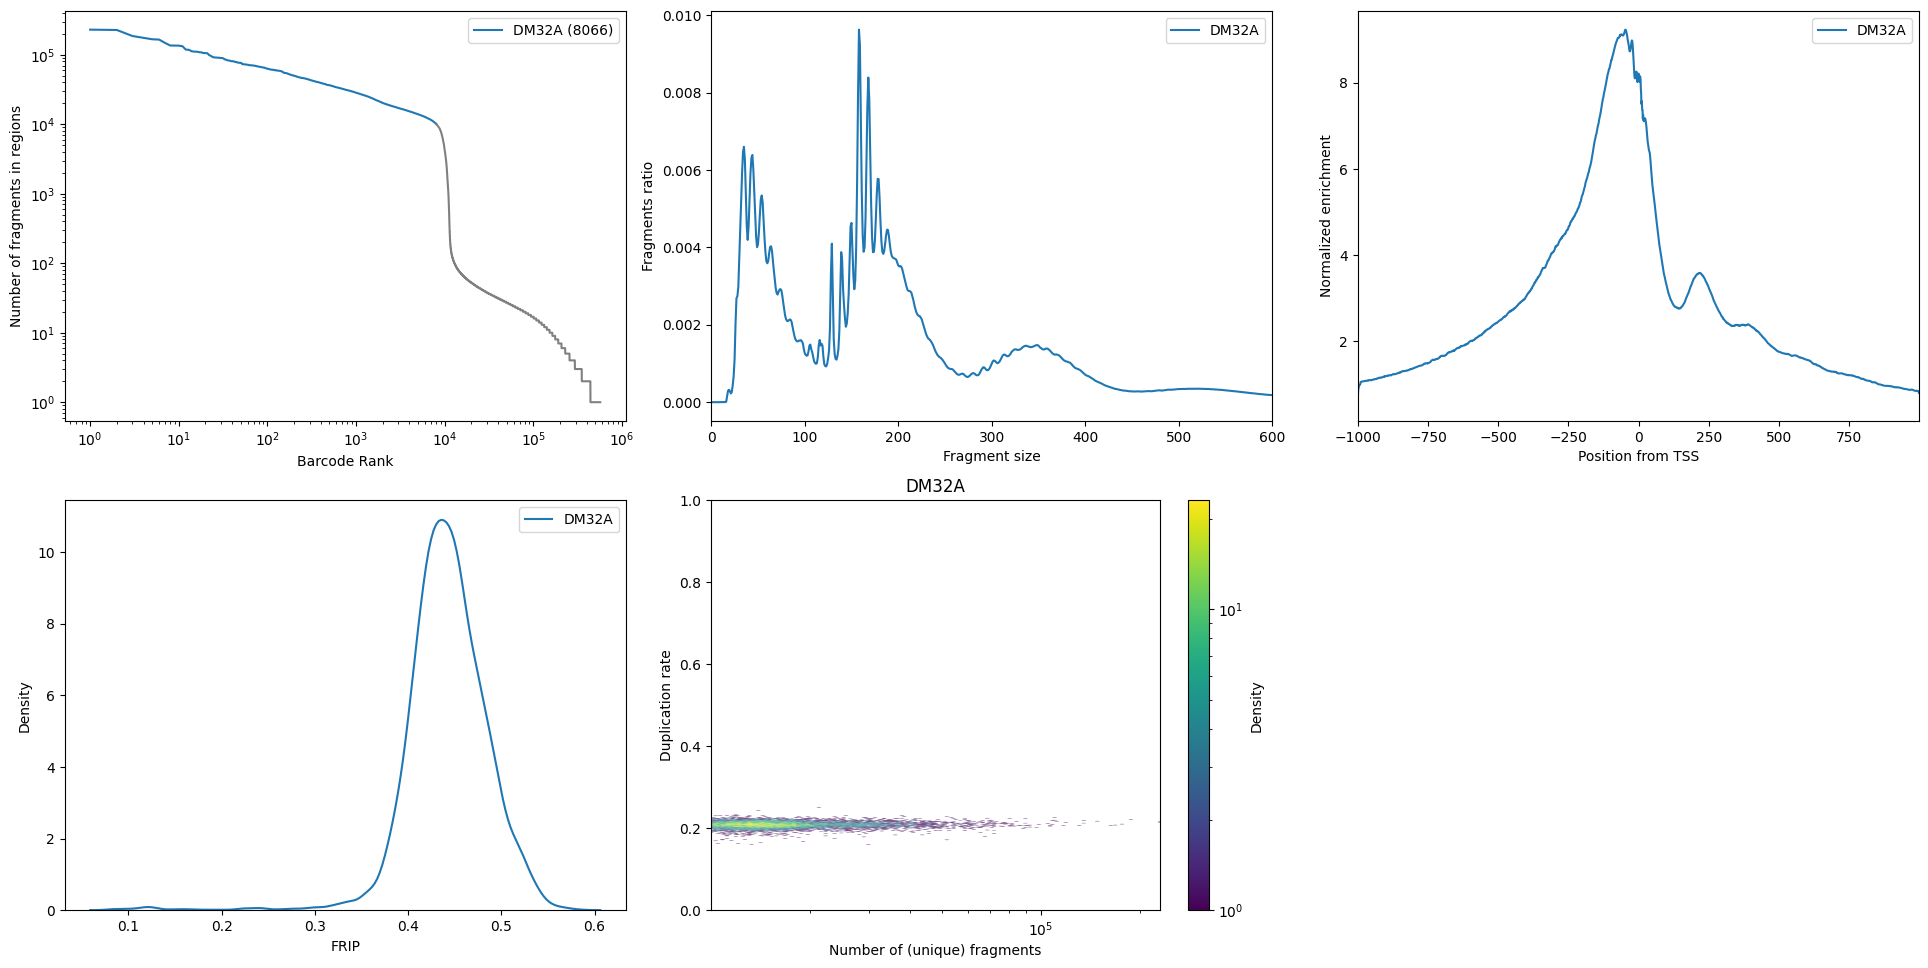

In [11]:
plot_sample_metrics(
    profile_data_dict,
    insert_size_distribution_xlim=[0,600],
    ncol=3,
    plot=True,
    duplicate_rate_as_hexbin = True
)

# Barcode level statistics

In [12]:
FRIP_NR_FRAG_fig = {}
FRIP_NR_FRAG_filter = {}
TSS_NR_FRAG_fig = {}
TSS_NR_FRAG_filter = {}
DR_NR_FRAG_fig = {}
for sample in metadata_bc.keys():
    
    # Return figure to plot together with other metrics, and cells passing filters
    FRIP_NR_FRAG_fig[sample], FRIP_NR_FRAG_filter[sample] = plot_barcode_metrics(
        metadata_bc[sample],
        var_x='Log_unique_nr_frag',
        var_y='FRIP',
        min_x=3,
        max_x=None,
        min_y=0.4,
        max_y=None,
        return_cells=True,
        return_fig=True,
        plot=False,
    )

    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_fig[sample], TSS_NR_FRAG_filter[sample] = plot_barcode_metrics(
        metadata_bc[sample],
        var_x='Log_unique_nr_frag',
        var_y='TSS_enrichment',
        min_x=3,
        max_x=None,
        min_y=4,
        max_y=None,
        return_cells=True,
        return_fig=True,
        plot=False,
    )

    # Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
    DR_NR_FRAG_fig[sample] = plot_barcode_metrics(
        metadata_bc[sample],
        var_x='Log_unique_nr_frag',
        var_y='Dupl_rate',
        min_x=3,
        max_x=None,
        min_y=None,
        max_y=None,
        return_cells=False,
        return_fig=True,
        plot=False,
        plot_as_hexbin = True
    )

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in

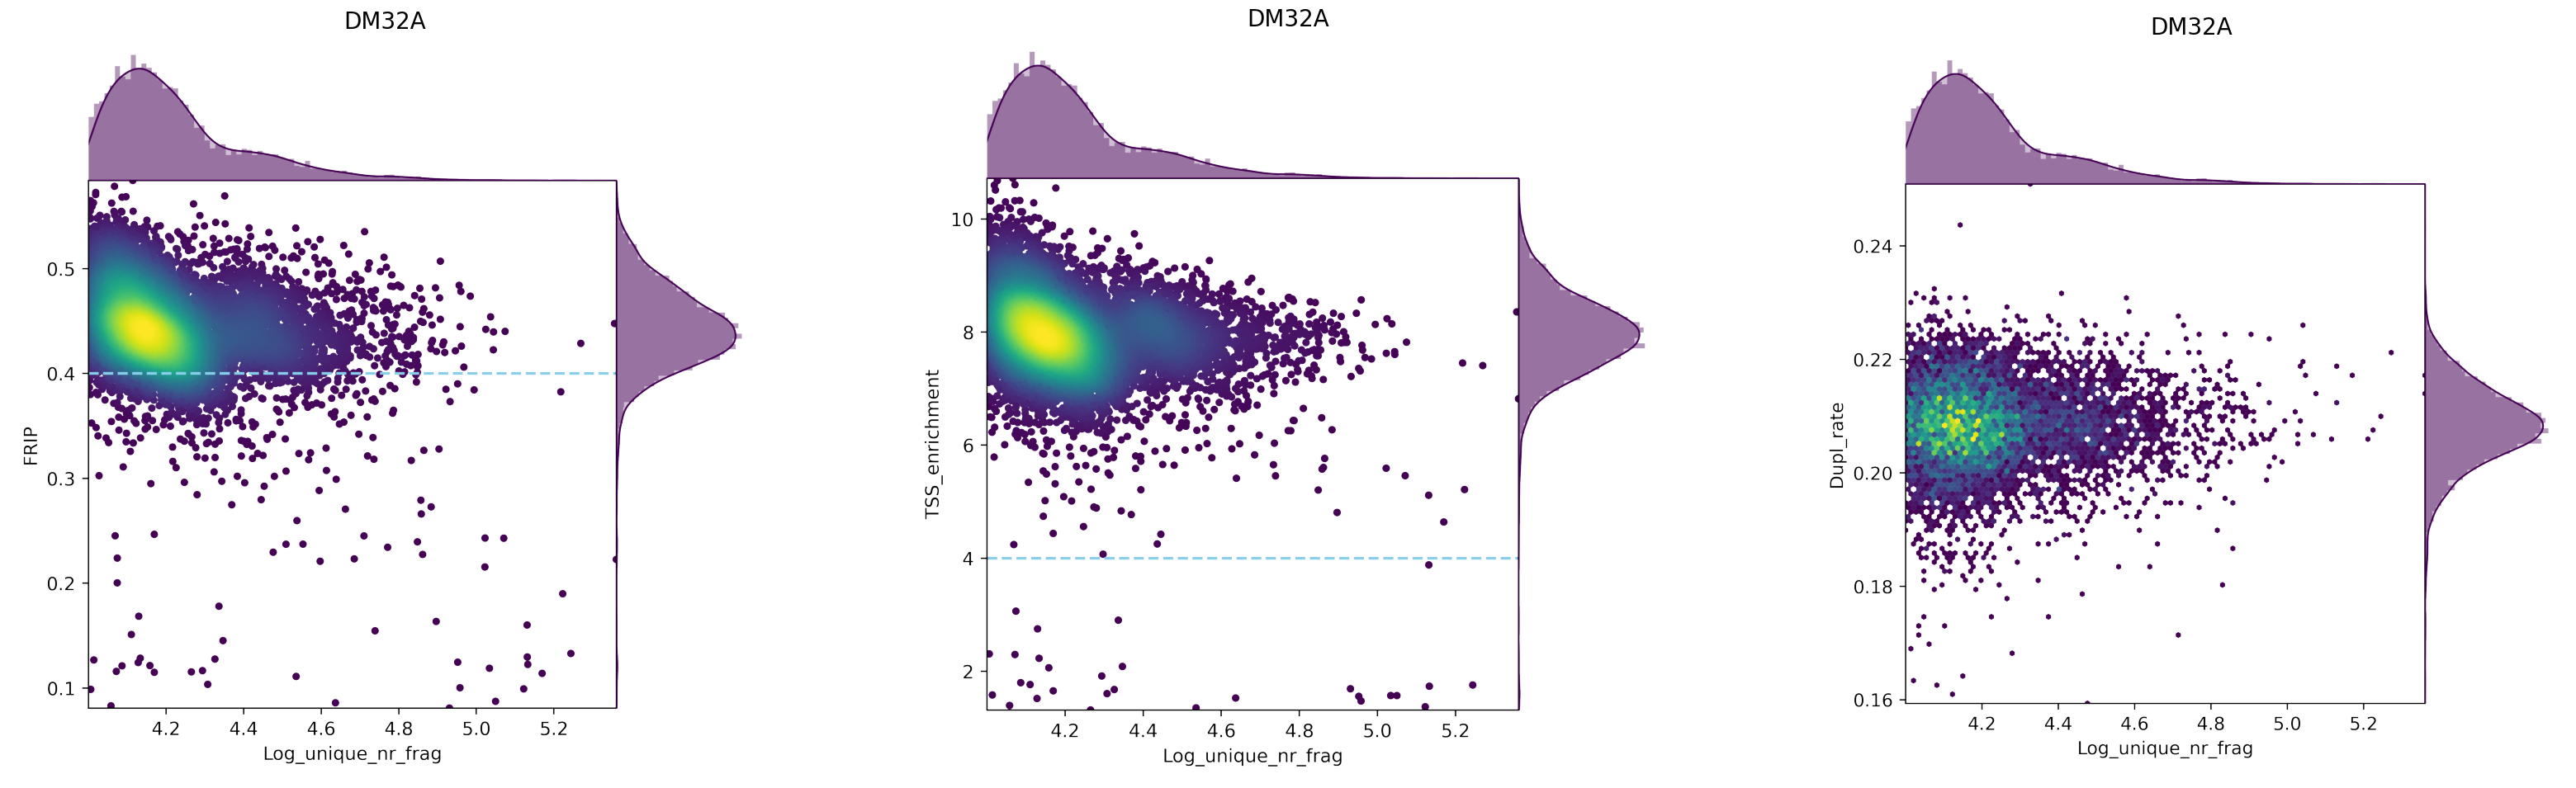

In [14]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40, 80))
i=1
for sample in FRIP_NR_FRAG_fig.keys():
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(FRIP_NR_FRAG_fig[sample]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(TSS_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(DR_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')

In [15]:
bc_passing_filters = {}
valid_bcs = []
for sample in fragments_dict.keys():
    print(sample)
    curr_bcs = list(set(FRIP_NR_FRAG_filter[sample]) & set(TSS_NR_FRAG_filter[sample]))
    if "A" in sample or "B" in sample:
        sample = sample.replace("A", "").replace("B", "")
    curr_bcs = [f"{sample}_{x}" for x in curr_bcs]
    bc_passing_filters[sample] = curr_bcs
    valid_bcs += curr_bcs
print(f"Total number of barcodes passing filters: {len(valid_bcs)}")

DM32A
Total number of barcodes passing filters: 7193


# DONE!

---